In [3]:
import sys
sys.path.append('../vectorsearch/')
import vectorsearch
import pandas as pd
import pickle
import nltk_helper
from spacy.en import English
nlp = English()

In [4]:
df_businesses = pd.read_pickle('../input/yelp_academic_dataset_business_SF.pickle')
reviews = pd.read_pickle('../output/bar_reviews_cleaned_and_tokenized_SF.pickle')

def get_bus_ids_city_state(city, state):
    return set(list(df_businesses.business_id[(df_businesses.city.str.lower()==city.lower()) 
                                     & (df_businesses.state.str.lower()==state.lower())].values))


training_users = pickle.load(open('../output/training_users.pickle', 'rb'))
test_users     = pickle.load(open('../output/test_users.pickle', 'rb'))

# Make the active review set training only 
review_train = reviews[reviews.user_id.isin(training_users)]
review_test = reviews[reviews.user_id.isin(test_users)]



In [5]:
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [26]:
from itertools import chain
from gensim.models import doc2vec
doc2vec_model = doc2vec.Doc2Vec.load('../output/doc2vec_bars_100.model')

def GetDocumentRank(review_text, real_bus_id, bus_ids_in_city_state):
    '''
    Given a document review, search businesses in that city, state and return the rank from the top of the list. 
    
    
    '''
    top_n = 1000 # Number of topics to choose for top of list. 
    rev_topic = np.array(vectorsearch.GetDocTopic(review_text, n_jobs=1),)
    
    
    #real_business = df_businesses[df_businesses.business_id==real_bus_id]
    #city, state = real_business.city.values[0], real_business.state.values[0]
    
    # Lookup only businesses in the city/state
    #bus_ids_in_city_state = get_bus_ids_city_state(city.strip().lower(), state.strip().lower())
    # Get the topic vector for the review 
    # topic_listings = [" ".join(vectorsearch.GetTopicWords(topic, ))  for topic in top_n_topics]
    # Find similarity with the businesses of interst (in the city state)
    top_bus_id, top_bus_sim = vectorsearch.FindBusinessSimilarityLDA(rev_topic, 
                                                                     business_ids=bus_ids_in_city_state,
                                                                     top_n=top_n, method='Hel')
    
    # Length of cleaned and tokenized document for segmentation.
    doc_length = vectorsearch.GetDocLength(review_text)
    # where in the results was the true business?
    try:
        rank = np.argwhere(top_bus_id==real_bus_id)[0][0]+1
    except:
        rank = float('NaN')
    return rank, doc_length




-


def get_bus_ids_city_state(city, state):
    bids =  set(list(df_businesses.business_id[(df_businesses.city==city) 
                                     & (df_businesses.state==state)].values))
    return bids




def RunValidation(review_set, city, state, method='LDA'):
    ranks, doc_lengths = [], [] 
    bids = get_bus_ids_city_state(city, state)    
    validation_set = review_set[review_set.business_id.isin(bids)]    

    for i_rev in range(len(validation_set)):
        #print i_rev
        row = validation_set.iloc[i_rev]
        #try:
        if (i_rev%50==0): 
            print '\r progress %i of'%i_rev, len(validation_set), 
        
        if method=='LDA':
            rank, doc_length = GetDocumentRank(row.text, row.business_id, bids)
            
        elif method=='doc2vec':
            rank, doc_length = GetDocumentRank_doc2vec(row.text, row.business_id, bids)
        ranks.append(rank)
        doc_lengths.append(doc_length)
        #except:
        #    pass

    return bids, ranks, doc_lengths


#%load_ext line_profiler
#%prun RunValidation(review_test, "San Francisco", "CA")

# -----------------------------------
# LDA results
# test_results = RunValidation(review_test, "San Francisco", "CA")
# print "TEST SET DONE"
# train_results = RunValidation(review_train[:100], "San Francisco", "CA")
# print "TRAIN SET DONE"


# doc2vec results

test_results = RunValidation(review_test.iloc[:], "San Francisco", "CA", method='doc2vec')
print "TEST SET DONE"
train_results = RunValidation(review_train[:100], "San Francisco", "CA")
print "TRAIN SET DONE"
# -----------------------------------
# doc2vec results

results = {'test_results':test_results, 'train_results':train_results}
with open('../output/validation_results_doc2vec_100_SF_withChunk.pickle', 'wb') as f:
    pickle.dump(results, f)



 progress 16750 of 16752 TEST SET DONE
TRAIN SET DONE


Num NaN's 6
Num NaN's 40
Num NaN's 2
Num NaN's 2


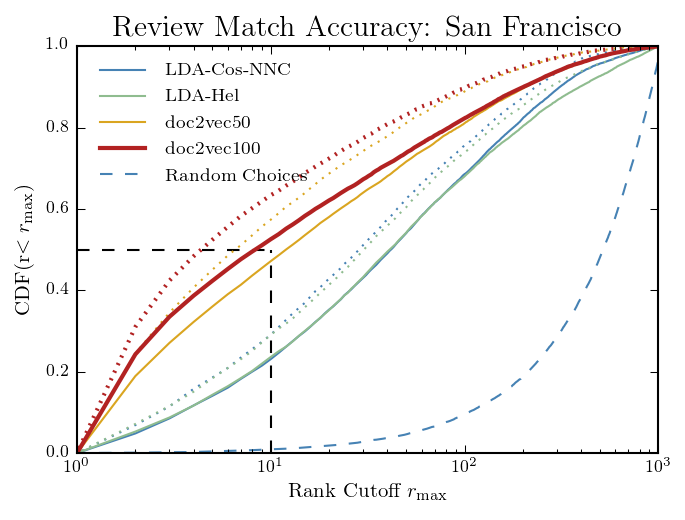

In [4]:
import pickle
from collections import OrderedDict
result_sets = OrderedDict(
    (('LDA-Cos-NNC', pickle.load(open('../output/validation_results_LDA_SF_noChunk.pickle', 'rb'))),
   #('LDA+NC Cos', pickle.load(open('../output/validation_results_LDA_SF_withChunk.pickle', 'rb'))),
   ('LDA-Hel', pickle.load(open('../output/validation_results_LDA_SF_withChunk_Hel.pickle', 'rb'))),
   ('doc2vec50', pickle.load(open('../output/validation_results_doc2vec_50_SF_withChunk.pickle', 'rb'))),
   ('doc2vec100', pickle.load(open('../output/validation_results_doc2vec_100_SF_withChunk.pickle', 'rb')))))
           


# ranks_train = np.array(train_results[1])
# n_businesses = len(train_results[0])
# doc_lengths_train = np.array(train_results[2])


def GetCDFDocLength(min_length):
    ranks_tmp = ranks[doc_lengths>min_length]
    CDF = np.array([np.sum(ranks_tmp<i) for i in range(n_businesses)])/float(len(ranks_tmp))
    return CDF


colors={'LDA-Cos-NNC':'steelblue','LDA-Hel':'darkseagreen', 'doc2vec50':'goldenrod', 'doc2vec100':'firebrick'}

for key, result_set in result_sets.items():  
    ranks = np.array(result_set['test_results'][1])
    n_businesses = len(result_set['test_results'][0])
    doc_lengths = np.array(result_set['test_results'][2])
    print "Num NaN's", np.sum(np.isnan(ranks))
    doc_lengths = doc_lengths[~np.isnan(ranks)]
    ranks = ranks[~np.isnan(ranks)]

    for min_length in [0,50,]:
        CDF = GetCDFDocLength(min_length)
        alpha=1
        label=key
        linestyle="-"
        linewidth=1
        if min_length==50:
            alpha=1
            label=None
            linestyle=":"
        if key=='doc2vec100':
            linewidth=2
        plt.plot(range(n_businesses),CDF, label=label, color=colors[key], alpha=alpha, 
                 linestyle=linestyle, linewidth=linewidth)


#     CDF = np.array([np.sum(ranks_train<i) for i in range(n_businesses)])/float(len(ranks_train))
#     plt.plot(range(n_businesses), CDF, label=r'LDA Training Set', linestyle=':')



# Random Choices....
random_choices = np.random.randint(1, n_businesses, len(ranks))
CDF = np.array([np.sum(random_choices<i) for i in range(n_businesses)])/float(len(random_choices))
plt.plot(range(n_businesses), CDF, label='Random Choices', linestyle='--')

plt.vlines(10, 0, .5, alpha=1, linestyle='--' )
plt.hlines(.5, 1, 1e1, alpha=1, linestyle='--' )

plt.legend(loc=2, frameon=False, handlelength=3)
plt.xscale('log')
plt.xlim(1,1e3)
plt.xlabel(r'Rank Cutoff $r_{\rm max}$')
plt.ylabel(r'CDF(r$<r_{\rm max}$)')
plt.title('Review Match Accuracy: San Francisco')

In [37]:
# import yelp

# yelp_api = yelp.Api(consumer_key='SddBgAA4qAbxz-UhAS0D7A',
#                     consumer_secret='z-d2Q7yB963kMcusvLVm9I2Jylg',
#                     access_token_key='KL574SXMJijEoO1_poHKhm6gHnSbwNlS',
#                     access_token_secret='bn7i1wGZ8hNK5MLuykvMwfpEB4g')


# def SearchYelpReviews(review, location, real_bus_URL):
#     search_results = yelp_api.Search(term=review, location=location, 
# #                                  cll=str(lat)+','+str(lon), radius_filter=radius, 
#                                  limit=20, category_filter='bars',) # location and search term are required
    
#     for i, bus in enumerate(search_results.businesses):
#         if bus.url == real_bus_URL:
#             return i+1
#         else:
#             return 999

# import nltk_helper
# from itertools import chain 

# def RunValidationYelp(review_set, city, state):
    
#     ranks, doc_lengths = [], [] 
#     bids = get_bus_ids_city_state(city, state)
#     validation_set = review_set[review_set.business_id.isin(bids)]
    
    
#     for i_rev in range(50):#len(validation_set)):
#         row = validation_set.iloc[i_rev]

#         if (i_rev%50==0): 
#             print '\r progress %i of'%i_rev, len(validation_set), 

#         real_URL = df_businesses.URL[row.business_id==df_businesses.business_id].values[0]
#         text_cleaned = nltk_helper.clean_and_tokenize(row.text)
#         text_cleaned = ",".join(list(chain.from_iterable(text_cleaned))[:8])
#         #print text_cleaned
#         rank = SearchYelpReviews(text_cleaned,
#                                  location=", ".join([city, state]), real_bus_URL=real_URL )
#         ranks.append(rank)
#     return ranks
        
        
# ranks = RunValidationYelp(review_test, 'San Francisco', 'CA')




# #search_results.businesses[0].url = search_results.businesses[0].url.split('?')[0]

In [15]:
print len(set(list(df_businesses.business_id[(df_businesses.city.str.lower()=='San Francisco'.lower()) 
                                     & (df_businesses.state.str.lower()=='ca')].values)))

1035


In [23]:
def get_bus_ids_city_state(city, state):
    return set(list(df_businesses.business_id[(df_businesses.city.str.lower()==city.lower()) 
                                     & (df_businesses.state.str.lower()==state.lower())].values))

len(get_bus_ids_city_state('San Francisco', 'CA'))

1035

In [5]:
import pandas as pd 

bus_lda_vecs = pd.read_pickle('../output/business_LDA_vectors.pickle')
top_vecs = np.vstack(bus_lda_vecs.topic_vector.values)

top_vecs = (top_vecs.T/np.sum(top_vecs, axis=1)).T
print top_vecs.shape


def hel(p,q):
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q), axis=1) / np.sqrt(2)


print hel(top_vecs[0], top_vecs)


(5620, 30)
[ 0.          0.35656793  0.8043929  ...,  0.67698329  0.73591688
  0.97432134]


In [32]:
zip(*[(u'XVEKceEWZbSz1P6Roa8sCA', 0.6897120475769043), (u'uVqODB0tnRtp3kD9cDeNWw', 0.6226238012313843), (u'GkYUFGLqCfsnLk2zpxIx0w', 0.6200392842292786), (u'6SoHvHM0NJq35x4bCdfc3A', 0.602697491645813)])

[(u'XVEKceEWZbSz1P6Roa8sCA',
  u'uVqODB0tnRtp3kD9cDeNWw',
  u'GkYUFGLqCfsnLk2zpxIx0w',
  u'6SoHvHM0NJq35x4bCdfc3A'),
 (0.6897120475769043,
  0.6226238012313843,
  0.6200392842292786,
  0.602697491645813)]